<a href="https://colab.research.google.com/github/harini9804/fake-image-detection/blob/master/fine_tuning_with_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cp '/content/drive/My Drive/Colab Notebooks/weibo_data_split.zip' /content

In [2]:
!unzip weibo_data_split.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/weibo_data_split/train/real/real1118.jpg  
  inflating: /content/weibo_data_split/train/real/real1119.jpg  
  inflating: /content/weibo_data_split/train/real/real1120.jpg  
  inflating: /content/weibo_data_split/train/real/real1129.jpg  
  inflating: /content/weibo_data_split/train/real/real1130.jpg  
  inflating: /content/weibo_data_split/train/real/real1131.jpg  
  inflating: /content/weibo_data_split/train/real/real1137.jpg  
  inflating: /content/weibo_data_split/train/real/real1146.jpg  
  inflating: /content/weibo_data_split/train/real/real1150.jpg  
  inflating: /content/weibo_data_split/train/real/real1157.jpg  
  inflating: /content/weibo_data_split/train/real/real1166.jpg  
  inflating: /content/weibo_data_split/train/real/real1167.jpg  
  inflating: /content/weibo_data_split/train/real/real1169.jpg  
  inflating: /content/weibo_data_split/train/real/real1170.jpg  
  inflating: /content/weibo_data_split/

In [3]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import os

Using TensorFlow backend.


In [0]:
import numpy as np

In [0]:
# path to the model weights files.
weights_path = '../keras/examples/vgg19_weights.h5'
top_model_weights_path = '/content/drive/My Drive/Colab Notebooks/bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

In [0]:

base_dir = '/content/weibo_data_split'
train_data_dir = base_dir +'/train'
validation_data_dir = base_dir +'/validation'

nb_train_samples = 2*len(os.listdir(train_data_dir+'/fake'))
nb_validation_samples = 2*len(os.listdir(validation_data_dir+'/fake'))
epochs = 50
batch_size = 64

In [7]:
# build the VGG19 network
model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

80142336/80134624 [==============================] - 7s 0us/step
Model loaded.


In [0]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [0]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [0]:
new_model = Sequential()
for l in model.layers:
    new_model.add(l)


# CONCATENATE THE TWO MODELS
new_model.add(top_model)

In [12]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

In [11]:
new_model.layers[:16]

In [0]:
# set the
# to non-trainable (weights will not be updated)
for layer in new_model.layers[:18]:
    layer.trainable = False

In [16]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

In [0]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
new_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr = 0.001, momentum = 0.9),
              metrics=['accuracy'])

In [0]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 6794 images belonging to 2 classes.
Found 970 images belonging to 2 classes.


In [20]:
train_generator.class_indices

{'fake': 0, 'real': 1}

In [0]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/weights_vgg19_orig_001.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
from keras.callbacks import ModelCheckpoint
#callback
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True,verbose=1)
callbacks_list = [cp_callback]

In [22]:
batch_size

64

In [23]:
# fine-tune the model
history = new_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks = callbacks_list)

Epoch 1/50
106/106 [==============================] - 109s 1s/step - loss: 0.9156 - accuracy: 0.5257 - val_loss: 0.6909 - val_accuracy: 0.5323

Epoch 00001: val_loss improved from inf to 0.69091, saving model to /content/drive/My Drive/Colab Notebooks/weights_vgg19_orig_001.01-0.69.hdf5
Epoch 2/50
106/106 [==============================] - 105s 988ms/step - loss: 0.6845 - accuracy: 0.5562 - val_loss: 0.6592 - val_accuracy: 0.5773

Epoch 00002: val_loss improved from 0.69091 to 0.65925, saving model to /content/drive/My Drive/Colab Notebooks/weights_vgg19_orig_001.02-0.66.hdf5
Epoch 3/50
106/106 [==============================] - 104s 984ms/step - loss: 0.6850 - accuracy: 0.5605 - val_loss: 0.6727 - val_accuracy: 0.5784

Epoch 00003: val_loss did not improve from 0.65925
Epoch 4/50
106/106 [==============================] - 105s 987ms/step - loss: 0.6729 - accuracy: 0.5814 - val_loss: 0.6606 - val_accuracy: 0.6093

Epoch 00004: val_loss did not improve from 0.65925
Epoch 5/50
106/106 [=

In [0]:
import matplotlib.pyplot as plt


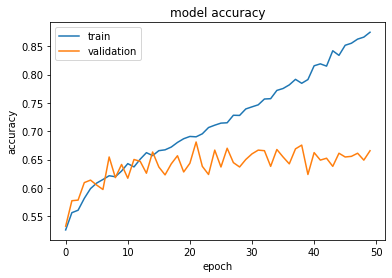

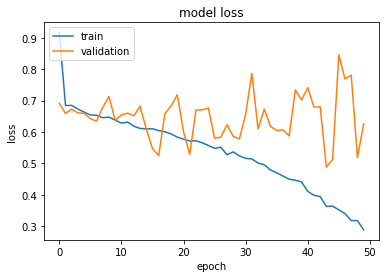

In [25]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()